In [1]:
import gym
from gym import spaces
import numpy as np
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
from stable_baselines3.common.env_checker import check_env
from stable_baselines3 import DQN, PPO, A2C
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.results_plotter import load_results, ts2xy
from tensorflow.keras.backend import clear_session #not sure if we need this but it does not hurt
import matplotlib.pyplot as plt

In [2]:
# randomly places a ship on a board
def set_ship(ship, ships, board, ship_locs):

    grid_size = board.shape[0]
    
    done = False
    while not done:
        init_pos_i = np.random.randint(0, grid_size)
        init_pos_j = np.random.randint(0, grid_size)
                    
        # for a cruiser, if init_oos_i = 0, move forward horizontally (+1)
        # for a cruiser, if init_oos_j = 0, move downward vertically (+1)
        move_j = grid_size - init_pos_j - ships[ship]# horizontal
        if move_j > 0:
            move_j = 1
        else:
            move_j = -1
        move_i = grid_size - init_pos_i - ships[ship] # vertical
        if move_i > 0:
            move_i = 1
        else:
            move_i = -1
        # choose if placing ship horizontally or vertically
        choice_hv = np.random.choice(['h', 'v']) # horizontal, vertical
        if choice_hv == 'h': #horizontal
            j = [(init_pos_j + move_j*jj) for jj in range(ships[ship])]
            i = [init_pos_i for ii in range(ships[ship])]
            pos = set(zip(i,j))     
            if all([board[i,j]==0 for (i,j) in pos]):
                done = True
        elif choice_hv == 'v':
            i = [(init_pos_i + move_i*ii) for ii in range(ships[ship])]
            j = [init_pos_j for jj in range(ships[ship])]
            pos = set(zip(i,j))        
            #check if empty board in this direction
            if all([board[i,j]==0 for (i,j) in pos]):
                done = True
    # set ship - see convention
    for (i,j) in pos:
        board[i,j] = 1
        ship_locs[ship].append((i,j))
    
    return board, ship_locs

def board_rendering(grid_size, board):
    for i in range(grid_size):
        print("-"*(4*grid_size+2))
        for j in range(grid_size):
            current_state_value = board[i,j]
            current_state = ('S' if current_state_value==1 else ' ')
            print(" | ", end="")
            print(current_state, end='')
        print(' |')
    print("-"*(4*grid_size+2))

In [3]:
class BattleshipEnv(gym.Env):
    
    """Custom Environment that follows gym interface"""
    """see https://github.com/openai/gym/blob/master/gym/core.py"""
    
    metadata = {'render.modes': ['human']} 


    def __init__(self, enemy_board, ship_locs, grid_size, ships):
        
        super(BattleshipEnv, self).__init__()
        
        #ships
        self.ships = ships
        
        # board size
        self.grid_size = grid_size 
        # cell state encoding (empty, hit, miss)
        self.cell = {'E': 0, 'X': 1, 'O': -1} 
        # boards, actions, rewards
        self.board = self.cell['E']*np.ones((self.grid_size, self.grid_size), dtype='int')
        # enemy_board must be encoded with 0: empy and 1: ship cell
        self.is_enemy_set = False
        self.enemy_board = enemy_board
        self.ship_locs = ship_locs
        if self.enemy_board is None:
            self.enemy_board = 0*np.ones((self.grid_size, self.grid_size), dtype='int')
            for ship in self.ships:
                self.ship_locs[ship] = []
                self.enemy_board, self.ship_locs = set_ship(ship, self.ships, self.enemy_board, self.ship_locs)
            self.is_enemy_set = True
        # reward discount
        self.rdisc = 0
        self.legal_actions = [] # legal (empty) cells available for moves
        for i in range(self.grid_size):
            for j in range(self.grid_size):
                self.legal_actions.append((i,j))# this gets updated as an action is performed
        
        # Define action and observation space
        # They must be gym.spaces objects
        # In our case the action space is discrete: index of action
        self.action_space = spaces.Discrete(self.grid_size * self.grid_size)
        # The observation will be the state or configuration of the board
        self.observation_space = spaces.Box(low=-1, high=1,shape=(self.grid_size, self.grid_size), 
                                            dtype=np.int)

    # action will be an index in action_space if from epsilon-greedy
    # or from model prediction
    def step(self, action):
                        
        # board situation before the action
        state = self.board.copy()        
        empty_cnts_pre, hit_cnts_pre, miss_cnts_pre = self.board_config(state)
        
        # action coordinates generated or predicted by the agent in the action_space
        i, j = np.unravel_index(action, (self.grid_size,self.grid_size))
        
        #print('action', action, 'coords', i, j)
        #print('legal_actions', self.legal_actions)
        
        # lose 1 point for any action
        reward = -1
        # assign a penalty for each illegal action used instead of a legal one
        if (i,j) not in self.legal_actions:
            reward -= 2*self.grid_size
            action_idx = np.random.randint(0,len(self.legal_actions))
            
            i,j = self.legal_actions[action_idx]                
            action = np.ravel_multi_index((i,j), (self.grid_size,self.grid_size))
        
        # set new state after performing action (scoring board is updated)
        self.set_state((i,j))
        # update legal actions and action_space
        self.set_legal_actions((i,j))

        # new state on scoring board - this includes last action
        next_state = self.board
               
        # board situation after action
        empty_cnts_post, hit_cnts_post, miss_cnts_post = self.board_config(next_state)

        # game completed?
        done = bool(hit_cnts_post == sum(self.ships.values()))
                    
        # reward for a hit
        if hit_cnts_post-hit_cnts_pre==1: 
            # Update hit counts and use it to reward
            r_discount = 1#0.5**self.rdisc
            rp = (self.grid_size*self.grid_size if done else self.grid_size)
            reward += rp*r_discount
            #print('HIT!!!')
            
        #if done:
        #    print('done')
            
        # we discount the reward for a subsequent hit the longer it takes to score it
        # after a hit, zero the discount 
        # don't start discounting though, if first hit hasn't happened yet
        #if hit_cnts_post-hit_cnts_pre==1 or hit_cnts_pre==0:
        #    self.rdisc = 0
        #else:
        #    self.rdisc += 1
                    
        reward = float(reward)
            
        #print('reward:', reward)
        # store the current value of the portfolio here
        info = {}

        return next_state, reward, done, info


    
    def reset(self):
        # Reset the state of the environment to an initial state
        """
        Important: the observation must be a numpy array
        :return: (np.array) 
        """
        
        self.board = self.cell['E']*np.ones((self.grid_size, self.grid_size), dtype='int')
        
        self.legal_actions = [] # legal (empty) cells available for moves
        for i in range(self.grid_size):
            for j in range(self.grid_size):
                self.legal_actions.append((i,j))# this gets updated as an action is performed
               
        # generate a random board again if it was set randomly before
        if self.is_enemy_set:
            self.enemy_board = 0*np.ones((self.grid_size, self.grid_size), dtype='int')
            self.ship_locs = {}
            for ship in self.ships:
                self.ship_locs[ship] = []
                self.enemy_board, self.ship_locs = set_ship(ship, self.ships, self.enemy_board, self.ship_locs)

        self.rdisc = 0

        return self.board
    
    # Render the environment to the screen
    # board (i,j)
    ## ------------>j
    ## | (0,0) | (0,1) | (0,2) | |
    ## | (1,0) | (1,1) | (1,2) | |
    ##                           v i
    def render(self, mode='human'):
        for i in range(self.grid_size):
            print("-"*(4*self.grid_size+2))
            for j in range(self.grid_size):
                current_state_value = self.board[i,j]
                current_state = list(self.cell.keys())[list(self.cell.values()).index(current_state_value)]
                current_state = (current_state if current_state!='E' else ' ')
                print(" | ", end="")
                print(current_state, end='')
            print(' |')
        print("-"*(4*self.grid_size+2))
        
    ####### HELPER FUNCTIONS ###########
    
    def board_config(self, state):
        uni_states, uni_cnts = np.unique(state.ravel(), return_counts=True)
        empty_cnts = uni_cnts[uni_states==self.cell['E']]
        hit_cnts = uni_cnts[uni_states==self.cell['X']]
        miss_cnts = uni_cnts[uni_states==self.cell['O']]
        if len(empty_cnts)==0:
            empty_cnts = 0
        else:
            empty_cnts = empty_cnts[0]
        if len(hit_cnts)==0:
            hit_cnts = 0
        else:
            hit_cnts = hit_cnts[0]
        if len(miss_cnts)==0:
            miss_cnts = 0
        else:
            miss_cnts = miss_cnts[0]
        
        return empty_cnts, hit_cnts, miss_cnts

    # set board configuration and state value after player action
    def set_state(self, action):
        i , j = action
        if self.enemy_board[i,j]==1:
            self.board[i,j]=self.cell['X']
        else:
            self.board[i,j]=self.cell['O']

    # set legal actions (empty board locations)
    def set_legal_actions(self, action):
        if action in self.legal_actions:
            self.legal_actions.remove(action)
            

## Validate environment with either random defined ship on 5x5 board

In [4]:
# ships
ships = {}
ships['cruiser'] = 3

grid_size = 5
# for pre-determined board
# enemy_board = 0*np.ones((grid_size, grid_size), dtype='int')
# enemy_board[0,1] = 1
# enemy_board[1,1] = 1
# enemy_board[2,1] = 1
# ship_locs = {}
# ship_locs['cruiser'] = [(0,1),(1,1),(2,1)]
# env = BattleshipEnv(enemy_board=enemy_board, ship_locs=ship_locs, grid_size=grid_size, ships=ships)
# for random board
env = BattleshipEnv(enemy_board=None, ship_locs={}, grid_size=grid_size, ships=ships)
check_env(env, warn=True)

C:\Users\enes1\AppData\Local\Temp/ipykernel_18684/2322792659.py:45: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype=np.int)
C:\Users\enes1\anaconda3\lib\site-packages\stable_baselines3\common\env_checker.py:190: UserWarning: Your observation  has an unconventional shape (neither an image, nor a 1D vector). We recommend you to flatten the observation to have only a 1D vector or use a custom policy to properly process the data.
  warnings.warn(


In [5]:
env.enemy_board, env.ship_locs

(array([[0, 1, 1, 1, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0]]),
 {'cruiser': [(0, 1), (0, 2), (0, 3)]})

In [6]:
# Test environment
# ships
ships = {}
ships['cruiser'] = 3

grid_size=5
env = BattleshipEnv(enemy_board=None, ship_locs={}, grid_size=grid_size, ships=ships)

for ep in range(2):
    print('Episode', ep)
    obs = env.reset()
    #env.render()
    #print(env.enemy_board)
    done = False
    t = 0
    while not done:
        action = env.action_space.sample()
        i, j = np.unravel_index(action, (grid_size,grid_size))    
        print("Action {}".format(t + 1), "row:", i, "index:", j)
        obs, reward, done, _ = env.step(action)
        print('obs=', obs, 'reward=', reward, 'done=', done)
        env.render()
        t += 1
        if done:
            print("Goal reached!", "reward=", reward)

C:\Users\enes1\AppData\Local\Temp/ipykernel_18684/2322792659.py:45: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype=np.int)


Episode 0
Action 1 row: 1 index: 1
obs= [[ 0  0  0  0  0]
 [ 0 -1  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]] reward= -1.0 done= False
----------------------
 |   |   |   |   |   |
----------------------
 |   | O |   |   |   |
----------------------
 |   |   |   |   |   |
----------------------
 |   |   |   |   |   |
----------------------
 |   |   |   |   |   |
----------------------
Action 2 row: 1 index: 1
obs= [[ 0  0  0  0  0]
 [ 0 -1  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  1  0]
 [ 0  0  0  0  0]] reward= -6.0 done= False
----------------------
 |   |   |   |   |   |
----------------------
 |   | O |   |   |   |
----------------------
 |   |   |   |   |   |
----------------------
 |   |   |   | X |   |
----------------------
 |   |   |   |   |   |
----------------------
Action 3 row: 3 index: 3
obs= [[ 0  0  0  0  0]
 [ 0 -1  0  0  0]
 [ 0  0  0 -1  0]
 [ 0  0  0  1  0]
 [ 0  0  0  0  0]] reward= -11.0 done= False
----------------------
 |   |   |   |   |   |

 |   |   | X |   |   |
----------------------
 |   |   |   |   |   |
----------------------
 |   |   | O |   |   |
----------------------
Action 5 row: 4 index: 3
obs= [[ 0  0  1  0  0]
 [ 0 -1  0  0  0]
 [ 0  0  1  0  0]
 [ 0  0  0  0  0]
 [ 0  0 -1 -1  0]] reward= -1.0 done= False
----------------------
 |   |   | X |   |   |
----------------------
 |   | O |   |   |   |
----------------------
 |   |   | X |   |   |
----------------------
 |   |   |   |   |   |
----------------------
 |   |   | O | O |   |
----------------------
Action 6 row: 0 index: 4
obs= [[ 0  0  1  0 -1]
 [ 0 -1  0  0  0]
 [ 0  0  1  0  0]
 [ 0  0  0  0  0]
 [ 0  0 -1 -1  0]] reward= -1.0 done= False
----------------------
 |   |   | X |   | O |
----------------------
 |   | O |   |   |   |
----------------------
 |   |   | X |   |   |
----------------------
 |   |   |   |   |   |
----------------------
 |   |   | O | O |   |
----------------------
Action 7 row: 2 index: 4
obs= [[ 0  0  1  0 -1]
 [ 0 -1  0  0  0

## Callback and Plotting

In [7]:
from stable_baselines3.common.callbacks import BaseCallback

class SaveOnBestTrainingRewardCallback(BaseCallback):
    """
    Callback for saving a model (the check is done every ``check_freq`` steps)
    based on the training reward (in practice, we recommend using ``EvalCallback``).

    :param check_freq: (int)
    :param log_dir: (str) Path to the folder where the model will be saved.
      It must contains the file created by the ``Monitor`` wrapper.
    :param verbose: (int)
    """
    def __init__(self, check_freq: int, episode_interval: int, log_dir: str, verbose=1):
        super(SaveOnBestTrainingRewardCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.episode_interval = episode_interval
        self.log_dir = log_dir
        self.save_path = os.path.join(log_dir, 'best_model.pkl')
        self.best_mean_reward = -np.inf

    def _init_callback(self) -> None:
        # Create folder if needed
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self) -> bool:
        if self.n_calls % self.check_freq == 0:
            # Evaluate policy training performance
            x, y = ts2xy(load_results(self.log_dir), 'timesteps')
            if len(x) > 0:
                # NOTE: when done is True, timesteps are counted and reported to the log_dir
                mean_reward = np.mean(y[-self.episode_interval:]) # mean reward over previous episode_interval episodes
                mean_moves = np.mean(np.diff(x[-self.episode_interval:])) # mean moves over previous 100 episodes
                if self.verbose > 0:
                    print(x[-1], 'timesteps') # closest to step_interval step number
                    print("Best mean reward: {:.2f} - Last mean reward per episode: {:.2f} - Last mean moves per episode: {:.2f}".format(self.best_mean_reward, 
                                                                                                   mean_reward, mean_moves))

                # New best model, you could save the agent here
                if mean_reward > self.best_mean_reward:
                    self.best_mean_reward = mean_reward
                    # Example for saving best model
                    if self.verbose > 0:
                        print("Saving new best model")
                    self.model.save(self.save_path)

        return True

In [8]:
def moving_average(values, window):
    """
    Smooth values by doing a moving average
    :param values: (numpy array)
    :param window: (int)
    :return: (numpy array)
    """
    weights = np.repeat(1.0, window) / window
    return np.convolve(values, weights, 'valid')


def plot_results(log_folder, window = 100, title='Learning Curve'):
    """
    plot the results

    :param log_folder: (str) the save location of the results to plot
    :param title: (str) the title of the task to plot
    """
    
    x, y = ts2xy(load_results(log_folder), 'timesteps')
    y = moving_average(y, window=window)
    y_moves = moving_average(np.diff(x), window = window) 
    # Truncate x
    x = x[len(x) - len(y):]
    x_moves = x[len(x) - len(y_moves):]

    title = 'Smoothed Learning Curve of Rewards (every ' + str(window) +' steps)'
    fig = plt.figure(title)
    plt.plot(x, y)
    plt.xlabel('Number of Timesteps')
    plt.ylabel('Rewards')
    plt.title(title)
    plt.show()

    title = 'Smoothed Learning Curve of Moves (every ' + str(window) +' steps)'
    fig = plt.figure(title)
    plt.plot(x_moves, y_moves)
    plt.xlabel('Number of Timesteps')
    plt.ylabel('Moves')
    plt.title(title)
    plt.show()

## Making the model

In [9]:
def callback(_locals, _globals):
    """
    Callback called at each step (for DQN an others) or after n steps (see ACER or PPO2)
    :param _locals: (dict)
    :param _globals: (dict)
    """
    global n_steps, best_mean_reward
    # Print stats every step_interval calls
    if (n_steps + 1) % step_interval == 0:
        # Evaluate policy training performance
        x, y = ts2xy(load_results(log_dir), 'timesteps')
        if len(x) > 0:
            # NOTE: when done is True, timesteps are counted and reported to the log_dir
            mean_reward = np.mean(y[-episode_interval:]) # mean reward over previous episode_interval episodes
            mean_moves = np.mean(np.diff(x[-episode_interval:])) # mean moves over previous episode_interval episodes
            print(x[-1], 'timesteps') # closest to step_interval step number
            print("Best mean reward: {:.2f} - Last mean reward per episode: {:.2f} - Last mean moves per episode: {:.2f}".format(best_mean_reward, 
                                                                                           mean_reward, mean_moves))

            # New best model, you could save the agent here
            if mean_reward > best_mean_reward:
                best_mean_reward = mean_reward
                # Example for saving best model
                print("Saving new best model")
                _locals['self'].save(log_dir + 'best_model.pkl')
    n_steps += 1
    # Returning False will stop training early
    return True

## Trainig on 5x5 board

In [10]:
clear_session()

# ships -- keep only one kind for 5x5 grid
ships = {}
ships['cruiser'] = 3

grid_size = 5
num_timesteps = 100000 # this is number of moves and not number of episodes

best_mean_reward, n_steps, step_interval, episode_interval = -np.inf, 0, 10000, 10000

# Instantiate the env
env = BattleshipEnv(enemy_board=None, ship_locs={}, grid_size=grid_size, ships=ships)

# wrap it
log_dir = "./gym/"
os.makedirs(log_dir, exist_ok=True)
env = Monitor(env, filename=log_dir, allow_early_resets=True)
env = DummyVecEnv([lambda: env])

# Train the agent - Note: best model is not save in Callback function for PPO2; save manually
model = A2C('MlpPolicy', env, verbose=0).learn(total_timesteps=num_timesteps, callback=callback)

C:\Users\enes1\AppData\Local\Temp/ipykernel_18684/2322792659.py:45: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype=np.int)


9986 timesteps
Best mean reward: -inf - Last mean reward per episode: -58.97 - Last mean moves per episode: 19.21
Saving new best model
19984 timesteps
Best mean reward: -58.97 - Last mean reward per episode: -54.80 - Last mean moves per episode: 18.68
Saving new best model
29994 timesteps
Best mean reward: -54.80 - Last mean reward per episode: -52.29 - Last mean moves per episode: 18.38
Saving new best model
40000 timesteps
Best mean reward: -52.29 - Last mean reward per episode: -49.28 - Last mean moves per episode: 17.95
Saving new best model
49992 timesteps
Best mean reward: -49.28 - Last mean reward per episode: -47.56 - Last mean moves per episode: 17.64
Saving new best model
59990 timesteps
Best mean reward: -47.56 - Last mean reward per episode: -45.77 - Last mean moves per episode: 17.37
Saving new best model
69999 timesteps
Best mean reward: -45.77 - Last mean reward per episode: -43.68 - Last mean moves per episode: 17.02
Saving new best model
79992 timesteps
Best mean rewa

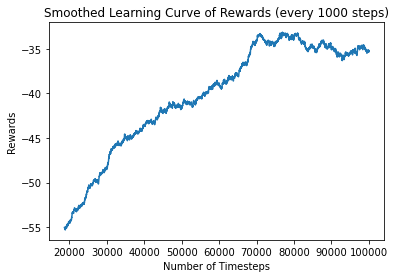

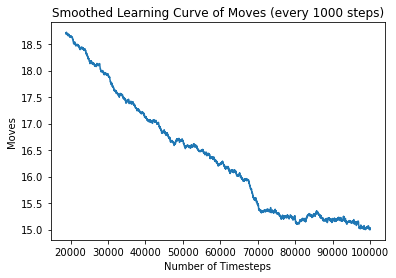

In [11]:
plot_results(log_dir, 1000)

In [12]:
model_best = A2C.load('./gym/best_model.pkl')

In [16]:
from IPython.display import clear_output
import time

ships = {}
ships['cruiser'] = 3

grid_size=5
enemy_board = 0*np.ones((grid_size, grid_size), dtype='int')
env = BattleshipEnv(enemy_board=None, ship_locs={}, grid_size=grid_size, ships=ships)
# give me time to setup recording
time.sleep(5)
for ep in range(1):
    obs = env.reset()
    ## 2 empty boards
    done = False
    nmoves = 0
    print('episode no.', ep, '# moves:', nmoves)
    env.render()
    env.render()
    time.sleep(5)
    clear_output(wait=True)        
    while not done:
        action, obs = model_best.predict(obs, deterministic=True)
        obs, _, done , _ = env.step(action)
        nmoves += 1
        print('episode no.', ep, '# moves:', nmoves)
        env.render()
        board_rendering(grid_size, env.enemy_board)
        time.sleep(np.random.uniform(1,3))
        clear_output(wait=True)        

episode no. 0 # moves: 5
----------------------
 |   |   |   |   |   |
----------------------
 |   |   |   |   |   |
----------------------
 |   |   |   | O | O |
----------------------
 |   |   |   |   |   |
----------------------
 |   | X | X | X |   |
----------------------
----------------------
 |   |   |   |   |   |
----------------------
 |   |   |   |   |   |
----------------------
 |   |   |   |   |   |
----------------------
 |   |   |   |   |   |
----------------------
 |   | S | S | S |   |
----------------------
